### Imports

In [94]:
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import corner
from astropy import constants as const
from gwpy.timeseries import TimeSeries
from pycbc.detector import Detector
import bilby
from pesummary.io import read
from math import pi
import h5py
from scipy.interpolate import InterpolatedUnivariateSpline
import lal
import lalsimulation as lalsim
import pycbc
from pycbc.filter.matchedfilter import overlap
from scipy.optimize import minimize_scalar

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3

### Helper functions

In [51]:
def GetPeakTime(time, data): 
    """ Grab the peak time of some data """
    t_peak = time[np.argmax(data)]
    return t_peak

def SubtractPeakTime(time, data): 
    """ Subtract the peak time of some data """
    t_peak = GetPeakTime(time, data)
    return time - t_peak
    
def dt_eval(time):
    """ Return the time step of a given time array """
    return (time[1] - time[0])

def swsh(s, modes, theta, phi, psi=0):
    """
    Return a value of a spin-weighted spherical harmonic of spin-weight s. 
    If passed a list of several modes, then a numpy array is returned with 
    SWSH values of each mode for the given point.
    For one mode:       swsh(s,[(l,m)],theta,phi,psi=0)
    For several modes:  swsh(s,[(l1,m1),(l2,m2),(l3,m3),...],theta,phi,psi=0)
    """
    import spherical_functions as sf
    import quaternion as qt
    return sf.SWSH(qt.from_spherical_coords(theta, phi), s, modes) * np.exp(1j * s * psi)

## Helper functions
def Ramp(time, t_s, t_r):
    """ Ramp function for tapering the waveform"""
    if (time < t_s):
        return 0.0
    elif time > (t_s + t_r):
        return 1.0
    else:
        t = (time - t_s)/t_r
        return t**5*(126 + t*(-420 + t*(540 + t*(-315 + 70*t))))

def EffectiveSpin(params_dict):
    """ Compute effective spin given a parameter dictionary """
    m_1 = params_dict['m_1']
    m_2 = params_dict['m_2']
    a_1 = params_dict['a_1'][2] ## grab z component of spin
    a_2 = params_dict['a_2'][2]
    return (a_1/m_1 + a_2/m_2)/(m_1 + m_2)

def MassParameters(BilbyRes):
    """ Compute individual masses and total mass given bilby result """
    q = 1.0/BilbyRes['mass_ratio']
    chirp = BilbyRes['chirp_mass']
    mass = chirp * (q/(1+q)**2)**(-3/5)
    m_2 = mass / (1 + q)
    m_1 = q*m_2
    return m_1, m_2, mass

def change_spin_convention(theta_jn, phi_jl, tilt1, tilt2, phi12, a1, a2, m1,
                           m2, f_ref, phi_orb=0.):
    iota, S1x, S1y, S1z, S2x, S2y, S2z = lalsim.SimInspiralTransformPrecessingNewInitialConditions(
                                             theta_jn, phi_jl, tilt1, tilt2, phi12, a1, a2,
                                             m1*lal.MSUN_SI, m2*lal.MSUN_SI, f_ref, phi_orb)
    spin1 = [S1x, S1y, S1z]
    spin2 = [S2x, S2y, S2z]
    return spin1, spin2, iota

def Compute_Spins(bilby_result):
    """ Given a bilby result, compute chi_1 and chi_2, as well as the inclination angle in the form 
        to be passed to a surrogate model """
    
    theta_jn = bilby_result['theta_jn']
    phi_jl = bilby_result['phi_jl']
    tilt1 = bilby_result['tilt_1']
    tilt2 = bilby_result['tilt_2']
    phi12 = bilby_result['phi_12']
    a1 = bilby_result['a_1']
    a2 = bilby_result['a_2']
    m1, m2, mass = MassParameters(bilby_result)
    phi_orb = bilby_result['phase'] ## phase of coalescence at some fiducial time 
    f_ref = 25 ## for now
    spin1, spin2, iota = change_spin_convention(theta_jn, phi_jl, tilt1, tilt2, phi12, a1, a2, m1,
                           m2, f_ref, phi_orb)
    return spin1, spin2, iota
    

### Grab waveform from frames files

In [83]:
def GetFramesData(p, det = 'H1'):
    
    sH = TimeSeries.read(source = p + '/Frames/' + det + '.gwf', channel=det+":LDAS_STRAIN")
    tH = np.array(sH.times)
    return tH, sH

### Grab injected parameters (for surrogate)

In [3]:
def GetInjectedParameters(p):
    """ Return a dictionary of values from the parameters.json file 
        corresponding to the frames, where p is the path to the file """
    
    f = open(p + '/parameters.json')
    params = json.load(f)
    f.close()
    return params

### Get Bilby parameters

In [4]:
def GetBilbyParameters(p):

    result = bilby.core.result.read_in_result(p + "/outdir/fast_tutorial_result.json")
    maxL_ind = np.argmax(result.posterior['log_likelihood'])
    maxL_point = result.posterior.iloc[maxL_ind]
    maxP_ind = np.argmax(result.posterior['log_likelihood'] + result.posterior['log_prior'])
    maxP_point = result.posterior.iloc[maxP_ind]
    
    return maxP_point

def GetBilbyDict(BilbyRes):
    
    BilbyDict = {}
    BilbyDict['dt'] = 1.0/2048.
    
    ## Reciprocal of the mass ratio 
    q = 1.0/BilbyRes['mass_ratio']
    BilbyDict['q'] = q
    
    m_1, m_2, mass = MassParameters(BilbyRes)
    BilbyDict['mass'] = mass
    BilbyDict['m_1'] = m_1
    BilbyDict['m_2'] = m_2
    
    BilbyDict['dist_mpc'] = BilbyRes['luminosity_distance'] 
    BilbyDict['f_low'] = 0.0
    BilbyDict['phi'] = BilbyRes['phase'] ## phase of coalescence (at some fiducial time)
    
    ## Spin computations
    chi_1, chi_2, theta = Compute_Spins(BilbyRes)
    print('spins:', chi_1, chi_2)
    
    BilbyDict['a_1'] = chi_1
    BilbyDict['a_2'] = chi_2
    chi_eff = EffectiveSpin(BilbyDict)
    BilbyDict['chi_eff'] = chi_eff
    
    print('iota:', theta, 'theta_jn:', BilbyRes['theta_jn'])
    BilbyDict['theta'] = theta ## Theta from the spin computation conventions
    
    BilbyDict['ra'] = BilbyRes['ra']
    BilbyDict['dec'] = BilbyRes['dec']
    BilbyDict['t_gps'] = BilbyRes['geocent_time']
    BilbyDict['pol'] = BilbyRes['psi'] ## polarization (angle on the sky of the pericenter wrt to interferometer -- degenerate for circular orbits
    return BilbyDict
    
    

### Get Surrogate waveforms

#### Import surrogate

In [5]:
import gwsurrogate
sur = gwsurrogate.LoadSurrogate('NRSur7dq4')

/home/maria.okounkova/.local/lib/python3.6/site-packages/gwtools/rotations.py:63: UserWarning: Could not import GWFrames, needed for rotations module
  _warnings.warn("Could not import GWFrames, needed for rotations module")
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwtools/__init__.py:11: UserWarning: Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.
  _warnings.warn("Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.")


setting __package__ to gwsurrogate.new so relative imports work
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
setting __package__ to gwsurrogate.new so relative imports work
setting __package__ to gwsurrogate.new so relative imports work


/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:245: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.t = h5file['t_ds'].value
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:272: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_coefs'%(key)].value,
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:273: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'bfOrders': group['%s_bfOrders'%(key)].value
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_%d_coefs'%(key, i)].value,
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_sur

Loaded NRSur7dq4 model


#### Evaluate Surrogate

In [82]:
## Surrogate evaluation
def EvaluateSurrogate(params_dict):
    """ Evaluate the surrogate waveform """
   
    """ Surrogate documentation: If inclination/phi_ref are specified, the complex strain (h =
             hplus -i hcross) evaluated at (inclination, pi/2 - phi_ref) on
             the sky of the reference frame is returned.

        In order to agree with NR convetions, need phi_ref = pi/2 - phi"""

    data = sur(params_dict['q'], params_dict['a_1'], params_dict['a_2'], \
               dt = params_dict['dt'], units = 'mks', M = params_dict['mass'], \
               dist_mpc = params_dict['dist_mpc'], f_low = params_dict['f_low'], \
               inclination = params_dict['theta'], ellMax = 4, \
               phi_ref = params_dict['phi'])

    time = data[0]
    h_plus = np.real(data[1])
    h_cross = -1 * np.imag(data[1])

    ## Now subtract off the peak time (this makes the spine interpolation easier)
    amp = np.sqrt(h_plus**2 + h_cross**2)
    time = time - time[np.argmax(amp)]

    return time, h_plus, h_cross, np.sqrt(h_plus**2 + h_cross**2)


## Read in the extrapolated modes
def ReadExtrapolatedModes(file, params_dict, interpolate = True):

    ## Convert distance to kpc and mass into solar masses
    mass = params_dict['mass']
    dist_mpc = params_dict['dist_mpc']
    theta = params_dict['theta']
    phi = params_dict['phi'] 
    dt = params_dict['dt']
    dist_kpc = dist_mpc * 1000 * const.kpc
    mass_msun = mass * const.M_sun
    
    ## Read in the data
    f = h5py.File(file, 'r')
    
    ## grab the length of the waveform first
    data = f['Extrapolated_N2.dir']['Y_l2_m2.dat']
    time = np.array(data[:,0])
    
    h_plus = np.zeros(len(time))
    h_cross = np.zeros(len(time))

    modes = [(l,m) for l in range(2,5) for m in range(-l, l+1)]
    for mode in modes: 
        
        ## Grab the mode in question
        l = mode[0]
        m = mode[1]
        
        data = f['Extrapolated_N2.dir']['Y_l' + str(l) + '_m' + str(m) + '.dat']
        real = np.array(data[:,1])
        imag = np.array(data[:,2])
        coeff = real + 1j * imag
        
        ## Multiply by the corresponding spin-weighted spherical harmonic
        Ylm = swsh(-2, [(l,m)], theta=theta, phi=phi, psi=0) 
        h = coeff * Ylm 
        
        ## Add to our h_plus and h_cross computations
        h_plus = h_plus + np.real(h)
        h_cross = h_cross - np.imag(h) 
        
        
    ## Apply the astrophysical parameters
    time = time*mass_msun*const.G/(const.c**3)
    h_plus = h_plus*const.G*mass_msun/((const.c)**2*dist_kpc)
    h_cross = h_cross*const.G*mass_msun/((const.c)**2*dist_kpc)

    ## Taper the waveform and apply the ramp (need to start the waveform at zero for this)
    time = time - time[0]
    ramp = np.array([Ramp(t.value, 0.1, 0.3) for t in time])
    
    h_plus = h_plus * ramp
    h_cross = h_cross * ramp
    
    # Now subtract off the peak time (this makes the spine interpolation easier)
    amp = np.sqrt(h_plus**2 + h_cross**2)
    time = time - time[np.argmax(amp)]
    
    if not interpolate:
        print("Not performing the interpolation")
        return time, h_plus, h_cross
    
    ## Now build the interpolants 
    cs_plus = InterpolatedUnivariateSpline(time, h_plus)
    cs_cross = InterpolatedUnivariateSpline(time, h_cross)

    ## Now create an evenly-spaced time array and interpolate the data 
    time_cs = np.arange(time[0].value, time[-1].value, dt)

    h_plus_cs = cs_plus(time_cs) 
    h_cross_cs = cs_cross(time_cs) 
    
    ## Return these new interpolated values
    ##return time, h_plus, h_cross, np.sqrt(h_plus**2 + h_cross**2)
    return time_cs, h_plus_cs, h_cross_cs, np.sqrt(h_plus_cs**2 + h_cross_cs**2)

## Time padding and projection to detectors
def ProjectToDetectors(ra, dec, pol, t0, plus, cross, time):
    '''
    ra - Right Ascension
    dec - Declination
    pol - Polarization Angle
    t0 - reference time for when signal reaches Hanford
    '''
    
    ## Grab the dt
    dt = dt_eval(time)
    
    d_H1 = Detector("H1")
    d_L1 = Detector("L1")
    
    # The time delay of the signal between the detectors
    t_delay_LH = d_L1.time_delay_from_detector(d_H1, ra, dec, t0)
    
    # Round the delay time to the nearest dt (this assumes that t_gps is a multiple of dt)
    t_delay_rounded_LH = round(t_delay_LH / dt) * dt

    #Antenna Patterns
    Fp_H1, Fc_H1 = d_H1.antenna_pattern(ra, dec, pol, t0)
    Fp_L1, Fc_L1 = d_L1.antenna_pattern(ra, dec, pol, t0 + t_delay_rounded_LH)    
    
    #project
    h_H1 = Fp_H1*plus + Fc_H1*cross
    h_L1 = Fp_L1*plus + Fc_L1*cross
    
    #Shift times
    time_H1 = time
    time_L1 = time + t_delay_rounded_LH
    
    return time_H1, h_H1, time_L1, h_L1
    
def PadAndProject(time, h_plus, h_cross, params_dict):
    """ Given a time, h_plus, and h_cross array, pad the data to the desired segment length, and project 
        to detectors.
        Within params_dict, 
        t_gps is the gps time of the event
        peak_time_in_segment is the time within the segment corresponding to the peak of the waveform (in sec)
        segmentt_length is the length of the segment (in sec)
        ra is the right ascention
        dec is the declination
        pol is the polarization
        """
       
    ## Grab the dt
    dt = dt_eval(time)
    
    ## The present peak time in the gravitational waveform (in secs)
    ## This is not the gps time, but rather should be ~0 from the surrogate / NR waveform 
    t_peak = time[np.argmax(h_plus**2 + h_cross**2)]
    
    ## Shift the times by the gps time, so that the peak of the waveform (in Handford)
    ## is now at t_gps
    time = time + params_dict['t_gps']

    ## Double check the peak time
    t_peak = time[np.argmax(h_plus**2 + h_cross**2)]
    #print("Shifted peak time: ", t_peak)
    
    ## Project data to the detectors -- both timeH and timeL % dt will be zero
    timeH, strainH, timeL, strainL = ProjectToDetectors(ra=params_dict['ra'], dec=params_dict['dec'], \
                                                        pol=params_dict['pol'], t0=params_dict['t_gps'], \
                                                        plus=h_plus, cross=h_cross, time=time)
    
    ## Return the projected data
    return timeH, strainH, timeL, strainL

### Get BW reconstructed waveforms


In [9]:
def GetBWDir(p):
    return p + '/BayesWave/Run/trigtime_1126259462.000000000_0.0_0.0_0/'

def GetMedianData(p, det = 'H1'):
    """ Given a coupling constant value and an SNR, return the columns of the median waveform data """
    
    ## Grab Livingston data
    f = GetBWDir(p) + "post/signal/signal_median_time_domain_waveform_" + det + ".dat"
    time, d1, d2, d3, d4, d5 = np.loadtxt(f, comments="#",usecols=([0,1,2,3,4,5]),unpack=True)
    
    ## Subtract peak time
    time = SubtractPeakTime(time, d1)
    
    return time, d1 #, d2, d3, d4, d5

def GetInjectedData(p, det = 'H1'):

    f = GetBWDir(p) + 'post/whitened_data_' + det + '.dat'
    data = np.loadtxt(f)
    
    s_rate = 2048 # Hz
    dt = 1.0/s_rate
    time = np.array([dt * t for t in range(len(data))])
    
    time = SubtractPeakTime(time, data)
    return time, data

### Compute overlaps

In [142]:
def dt_eval(time):
    """ Return the time step of a given time array """
    return (time[1] - time[0])

def df_eval(time):
    """ Return the delta_f of a given time array """
    delta_t = dt_eval(time)
    return 1.0/((time[-1] - time[0]) + delta_t)

def ComputeOverlap(time1, strain1, time2, strain2):
    """ Given two time-domain strains and the corresponding time arrays, 
        compute the overlap using pycbc """

    ## Construct time array to be interpolated onto, since the pycbc overlap computation
    ## requites the time arrays to be the same
    delta_t = dt_eval(time1)
    time = np.arange(start = max(time1[0], time2[0]), stop = min(time1[-1], time2[-1]), step = delta_t)
    delta_f = df_eval(time)
    
    ## Interpolate strains onto time array
    cs1 = InterpolatedUnivariateSpline(time1, strain1)
    cs2 = InterpolatedUnivariateSpline(time2, strain2)
    strain1 = cs1(time) 
    strain2 = cs2(time)

    ## Read in PSD and construct interpolant
    psd_file = "../PSDs/design/aLIGOZeroDetHighPower-PSD.txt"
    psd_frequencies, psd_vals = np.loadtxt(psd_file, comments="#",usecols=([0,1]),unpack=True)
    cs = InterpolatedUnivariateSpline(psd_frequencies, psd_vals)

    ## Interpolated PSD onto df-spaced values
    freqs = delta_f * np.array(range(len(time)))
    psd = cs(freqs)

    ## Timeseries and Frequency series objects for pycbc computation
    strain1_ts = pycbc.types.timeseries.TimeSeries(strain1, delta_t = delta_t, epoch = time[0])
    strain2_ts = pycbc.types.timeseries.TimeSeries(strain2, delta_t = delta_t, epoch = time[0])
    psd_fs = pycbc.types.frequencyseries.FrequencySeries(psd, delta_f = delta_f, epoch = time[0])

    overlap_val = overlap(vec1 = strain1_ts, vec2 = strain2_ts, psd = psd_fs, normalized = True, low_frequency_cutoff = 25, high_frequency_cutoff = 2048) 
    ## Take the square root of the overlap
    return np.sqrt(overlap_val)

### TODO: function here for two - detector overlap 

def OptimizePhase(timeH, strainH, timeL, strainL, param_dict):
    """ Given a time and a strain array in each detector that we want to compare against, and a dictionary of parameters, 
        iterate over possible phases for the surrogate in order to produce the phase with the largest
        overlap """
    
    def f(x):
        surrogate_dict = param_dict
        surrogate_dict['phi'] = x
        time_sur, h_plus_sur, h_cross_sur, amp_sur = EvaluateSurrogate(surrogate_dict)
        timeH_sur, strainH_sur, timeL_sur, strainL_sur = PadAndProject(time_sur, h_plus_sur, h_cross_sur, surrogate_dict)
        ov = ComputeOverlap(timeH, strainH, timeH_sur, strainH_sur)
        ## 1 minus the overlap since we're doing minimization
        return 1.0 - ov
    
    ## iterate from zero to 2 * pi
    res = minimize_scalar(f, bounds=(0, 2*pi), method = 'bounded')
    print(res.x)
    return(res.x)

### Plot reconstructions

In [141]:
## Base waveform
file = '/home/maria.okounkova/BeyondGRAnalysis/Waveforms/Lev5/dCS_Strain_0p0.h5'
truth_dict = GetInjectedParameters('/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/Test_FullSearchNoTiltNoSkyLoc_35_0p99')
time, h_plus, h_cross, amp = ReadExtrapolatedModes(file, truth_dict, interpolate = True)
timeH, strainH, timeL, strainL = PadAndProject(time, h_plus, h_cross, truth_dict)

In [145]:
## Optimal phase computation
phi_opt = OptimizePhase(timeH, strainH, timeL, strainL, truth_dict)
## Surrogate waveform
surrogate_dict = truth_dict
print("here")
surrogate_dict['phi'] = phi_opt
time_sur, h_plus_sur, h_cross_sur, amp_sur = EvaluateSurrogate(surrogate_dict)
timeH_sur, strainH_sur, timeL_sur, strainL_sur = PadAndProject(time_sur, h_plus_sur, h_cross_sur, surrogate_dict)
ov = ComputeOverlap(timeH, strainH, timeH_sur, strainH_sur)
print(ov)

/home/maria.okounkova/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt


2.265787894547262
here
0.9992058575226468


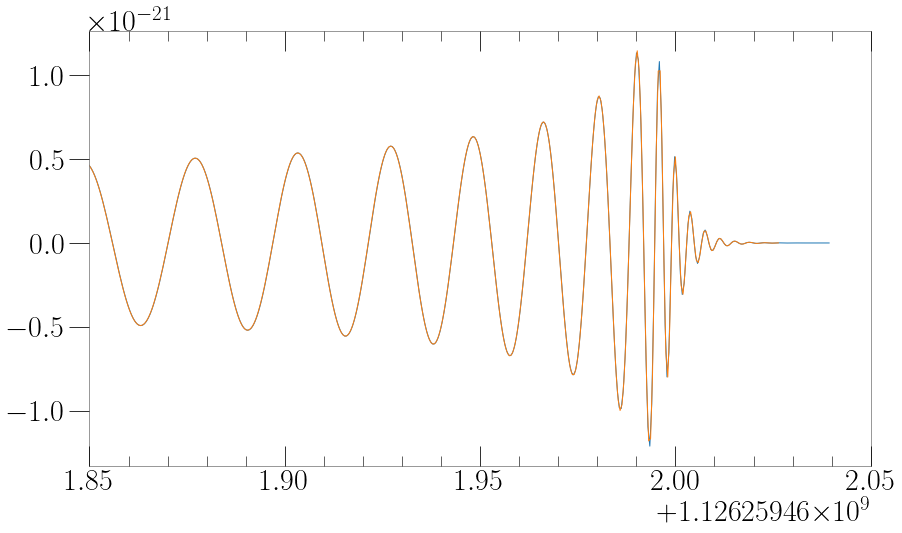

In [146]:
plt.figure(figsize=(14,8))
plt.plot(timeL, strainL, lw = 1.0)
plt.plot(timeL_sur, strainL_sur, lw = 1.0)
plt.grid()
plt.xlim(-0.15 + truth_dict['t_gps'], 0.05 + truth_dict['t_gps'])
plt.show()

In [137]:
p = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/Test_FullSearch_35_0p99'
bilby_result = GetBilbyParameters(p)
bilby_dict = GetBilbyDict(bilby_result)
bilby_dict['pol'] = truth_dict['pol'] ## because degenerate for circular orbits
bilby_dict['t_gps'] = truth_dict['t_gps']
print(bilby_dict)

spins: [-0.025427509750983363, 0.10740149942316106, -0.021820385582332957] [-0.04970435815533261, 0.0450830828935214, 0.020780848950056285]
iota: 2.926275209930525 theta_jn: 2.8803570295345833
{'dt': 0.00048828125, 'q': 1.1107337637817165, 'mass': 67.69200639322747, 'm_1': 35.6216394171734, 'm_2': 32.07036697605407, 'dist_mpc': 390.2263242169838, 'f_low': 0.0, 'phi': 5.79775602127945, 'a_1': [-0.025427509750983363, 0.10740149942316106, -0.021820385582332957], 'a_2': [-0.04970435815533261, 0.0450830828935214, 0.020780848950056285], 'chi_eff': 5.232052665854195e-07, 'theta': 2.926275209930525, 'ra': 2.0842634476846653, 'dec': -1.2788398471661397, 't_gps': 1126259462.0, 'pol': 0.824043851821}


/home/maria.okounkova/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:58: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)


In [138]:
bilby_dict

{'dt': 0.00048828125,
 'q': 1.1107337637817165,
 'mass': 67.69200639322747,
 'm_1': 35.6216394171734,
 'm_2': 32.07036697605407,
 'dist_mpc': 390.2263242169838,
 'f_low': 0.0,
 'phi': 5.79775602127945,
 'a_1': [-0.025427509750983363, 0.10740149942316106, -0.021820385582332957],
 'a_2': [-0.04970435815533261, 0.0450830828935214, 0.020780848950056285],
 'chi_eff': 5.232052665854195e-07,
 'theta': 2.926275209930525,
 'ra': 2.0842634476846653,
 'dec': -1.2788398471661397,
 't_gps': 1126259462.0,
 'pol': 0.824043851821}

In [74]:
bilby_dict['phi'] = -0.5
time_bil, h_plus_bil, h_cross_bil, amp_bil = EvaluateSurrogate(bilby_dict)
timeH_bil, strainH_bil, timeL_bil, strainL_bil = PadAndProject(time_bil, h_plus_bil, h_cross_bil, bilby_dict)

1126259462.0


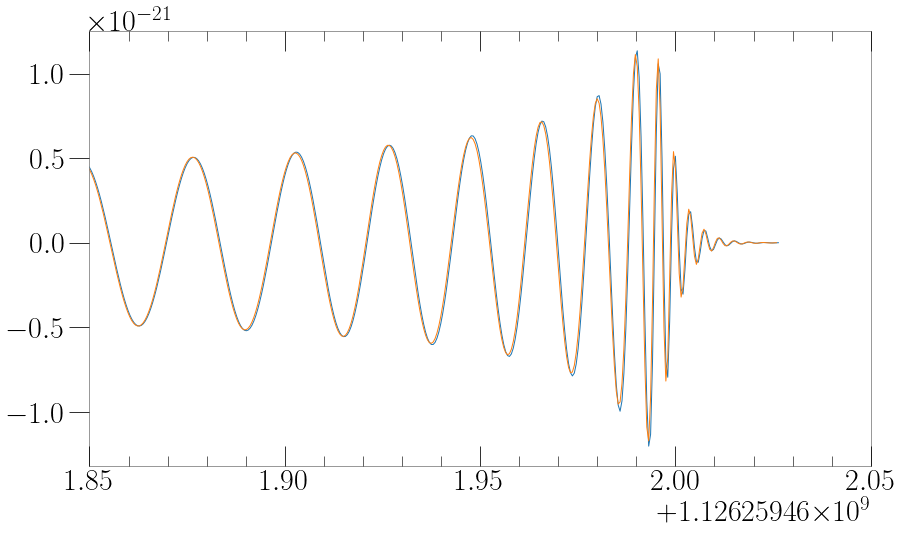

In [75]:
# plt.figure(figsize=(14,8))
# plt.plot(time_sur, h_cross_sur, lw = 1.0)
# plt.plot(time_bil, h_cross_bil, lw = 1.0)
# plt.xlim(-0.15, 0.05)
# plt.grid()
# plt.show()

plt.figure(figsize=(14,8))
plt.plot(timeL_sur, strainL_sur, lw = 1.0)
plt.plot(timeL_bil, strainL_bil, lw = 1.0)
plt.grid()
plt.xlim(-0.15 + truth_dict['t_gps'], 0.05 + truth_dict['t_gps'])
plt.show()